In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import OrdinalEncoder, LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from imblearn.over_sampling import SMOTE, BorderlineSMOTE, ADASYN
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.tree import export_graphviz
from sklearn.externals.six import StringIO
import pydotplus
from sklearn.metrics import classification_report
from google.colab import files

ModuleNotFoundError: ignored

In [2]:
app_df = pd.read_csv('/content/application_record.csv')
cr_df = pd.read_csv('/content/credit_record.csv')

In [3]:
app_df.head()
# applications for credit card record

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS
0,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1.0,0.0,0.0,NaN,2.0
1,5008805,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1.0,0.0,0.0,NaN,2.0
2,5008806,M,Y,Y,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,-21474,-1134,1,0.0,0.0,0.0,Security staff,2.0
3,5008808,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0.0,1.0,1.0,Sales staff,1.0
4,5008809,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0.0,1.0,1.0,Sales staff,1.0


In [4]:
cr_df.head()
# credit card history record
# ID is the application id
# Months balance number tells how many months back, 0 being current month, -1 the previous month

,ID,MONTHS_BALANCE,STATUS
0,5001711,0,X
1,5001711,-1,0
2,5001711,-2,0
3,5001711,-3,0
4,5001712,0,C


In [5]:
# we see that there are multiple entries for the same application id
cr_df['MONTHS_BALANCE'].value_counts()

-1     34436
-2     34209
 0     33856
-3     33854
-4     33365
       ...  
-56     2109
-57     1649
-58     1255
-59      820
-60      415
Name: MONTHS_BALANCE, Length: 61, dtype: int64

In [6]:
cr_df = cr_df.sort_values(['ID', 'MONTHS_BALANCE'], ascending = False)
cr_df.head(20)

,ID,MONTHS_BALANCE,STATUS
1048545,5150487,0,C
1048546,5150487,-1,C
1048547,5150487,-2,C
1048548,5150487,-3,C
1048549,5150487,-4,C
1048550,5150487,-5,C
1048551,5150487,-6,C
1048552,5150487,-7,C
1048553,5150487,-8,C
1048554,5150487,-9,C


In [7]:
cr_df = cr_df.groupby('ID').agg(max).reset_index()
# make a group by aggregating (collecting) maximum historical data available for the particular applicant ID

In [8]:
cr_df['STATUS'].value_counts()
# X no loan for that month
# C cleared loan that month
# 0 1-29 days past due
# 1 30-59 days past due
# 2 60-89 days past due
# 3 90-119 days past due
# 4 120-149 days past due
# 5 Overdue or bad debt

X    25005
C    14882
0     5161
1      821
5       54
2       49
3       10
4        3
Name: STATUS, dtype: int64

In [9]:
cr_df['STATUS'].replace({'C': 0, 'X': 0}, inplace = True)
cr_df['STATUS'] = cr_df['STATUS'].astype('int')
cr_df['STATUS'] = cr_df['STATUS'].apply(lambda x:1 if x>0 else 0)
cr_df['STATUS'].value_counts()

0    45048
1      937
Name: STATUS, dtype: int64

In [10]:
df = app_df.join(cr_df.set_index('ID'), on = 'ID', how = 'inner')
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 36105 entries, 0 to 49539
Data columns (total 20 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID                   36105 non-null  int64  
 1   CODE_GENDER          36105 non-null  object 
 2   FLAG_OWN_CAR         36105 non-null  object 
 3   FLAG_OWN_REALTY      36105 non-null  object 
 4   CNT_CHILDREN         36105 non-null  int64  
 5   AMT_INCOME_TOTAL     36105 non-null  float64
 6   NAME_INCOME_TYPE     36105 non-null  object 
 7   NAME_EDUCATION_TYPE  36105 non-null  object 
 8   NAME_FAMILY_STATUS   36105 non-null  object 
 9   NAME_HOUSING_TYPE    36105 non-null  object 
 10  DAYS_BIRTH           36105 non-null  int64  
 11  DAYS_EMPLOYED        36105 non-null  int64  
 12  FLAG_MOBIL           36105 non-null  int64  
 13  FLAG_WORK_PHONE      36105 non-null  float64
 14  FLAG_PHONE           36105 non-null  float64
 15  FLAG_EMAIL           36105 non-null 

In [11]:
df.isnull().sum()
# occupation type has some null values

ID                         0
CODE_GENDER                0
FLAG_OWN_CAR               0
FLAG_OWN_REALTY            0
CNT_CHILDREN               0
AMT_INCOME_TOTAL           0
NAME_INCOME_TYPE           0
NAME_EDUCATION_TYPE        0
NAME_FAMILY_STATUS         0
NAME_HOUSING_TYPE          0
DAYS_BIRTH                 0
DAYS_EMPLOYED              0
FLAG_MOBIL                 0
FLAG_WORK_PHONE            0
FLAG_PHONE                 0
FLAG_EMAIL                 0
OCCUPATION_TYPE        11214
CNT_FAM_MEMBERS            0
MONTHS_BALANCE             0
STATUS                     0
dtype: int64

In [12]:
df['CNT_CHILDREN'].value_counts()

0     24945
1      7424
2      3235
3       413
4        62
5        20
14        3
7         2
19        1
Name: CNT_CHILDREN, dtype: int64

In [13]:
df.head()

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,MONTHS_BALANCE,STATUS
0,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1.0,0.0,0.0,NaN,2.0,0,0
1,5008805,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1.0,0.0,0.0,NaN,2.0,0,0
2,5008806,M,Y,Y,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,-21474,-1134,1,0.0,0.0,0.0,Security staff,2.0,0,0
3,5008808,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0.0,1.0,1.0,Sales staff,1.0,0,0
4,5008809,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0.0,1.0,1.0,Sales staff,1.0,-22,0


In [14]:
binary_features = ['CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'FLAG_PHONE', 'FLAG_EMAIL']
continuous_features = ['CNT_CHILDREN','AMT_INCOME_TOTAL', 'DAYS_BIRTH', 'DAYS_EMPLOYED', 'CNT_FAM_MEMBERS']
cat_features = ['NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE']

In [15]:
df.drop(['MONTHS_BALANCE', 'OCCUPATION_TYPE', 'FLAG_MOBIL'], axis = 1, inplace = True)
# Dropping OCCUPATION_TYPE (lots of missing data) and FLAG_MOBIL (all values 1)

Converting ordinal categorical values into numbers:-
Note that these variables can have an order, for example a student earns less than a state servant.

Categorical values that can be assigned an order: Ordinal Encoder;
Categorical variables that cannot be assigned an order: Label Encoder

In [16]:
df['NAME_INCOME_TYPE'].unique()

array(['Working', 'Commercial associate', 'Pensioner', 'State servant',
       'Student'], dtype=object)

In [17]:
encoder = OrdinalEncoder(categories = [['Student', 'Pensioner', 'Working', 'Commercial associate', 'State servant']])
df.NAME_INCOME_TYPE = encoder.fit_transform(df.NAME_INCOME_TYPE.values.reshape(-1,1))
df['NAME_INCOME_TYPE'].unique()

array([2., 3., 1., 4., 0.])

In [18]:
encoder2 = LabelEncoder()

cat_features = ['NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE']
for i in cat_features:
  df[i] = encoder2.fit_transform(df[i].values.reshape(-1,1))

/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [19]:
df.head()

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,STATUS
0,5008804,M,Y,Y,0,427500.0,2.0,1,0,4,-12005,-4542,1.0,0.0,0.0,2.0,0
1,5008805,M,Y,Y,0,427500.0,2.0,1,0,4,-12005,-4542,1.0,0.0,0.0,2.0,0
2,5008806,M,Y,Y,0,112500.0,2.0,4,1,1,-21474,-1134,0.0,0.0,0.0,2.0,0
3,5008808,F,N,Y,0,270000.0,3.0,4,3,1,-19110,-3051,0.0,1.0,1.0,1.0,0
4,5008809,F,N,Y,0,270000.0,3.0,4,3,1,-19110,-3051,0.0,1.0,1.0,1.0,0


For binary features, we use pandas dummies, which assigns 1s and 0s

In [20]:
df = pd.get_dummies(df, columns = binary_features, drop_first = True)

In [21]:
df.head()

,ID,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_WORK_PHONE,CNT_FAM_MEMBERS,STATUS,CODE_GENDER_M,FLAG_OWN_CAR_Y,FLAG_OWN_REALTY_Y,FLAG_PHONE_1.0,FLAG_EMAIL_1.0
0,5008804,0,427500.0,2.0,1,0,4,-12005,-4542,1.0,2.0,0,1,1,1,0,0
1,5008805,0,427500.0,2.0,1,0,4,-12005,-4542,1.0,2.0,0,1,1,1,0,0
2,5008806,0,112500.0,2.0,4,1,1,-21474,-1134,0.0,2.0,0,1,1,1,0,0
3,5008808,0,270000.0,3.0,4,3,1,-19110,-3051,0.0,1.0,0,0,0,1,1,1
4,5008809,0,270000.0,3.0,4,3,1,-19110,-3051,0.0,1.0,0,0,0,1,1,1


Plotting Different Variables:-

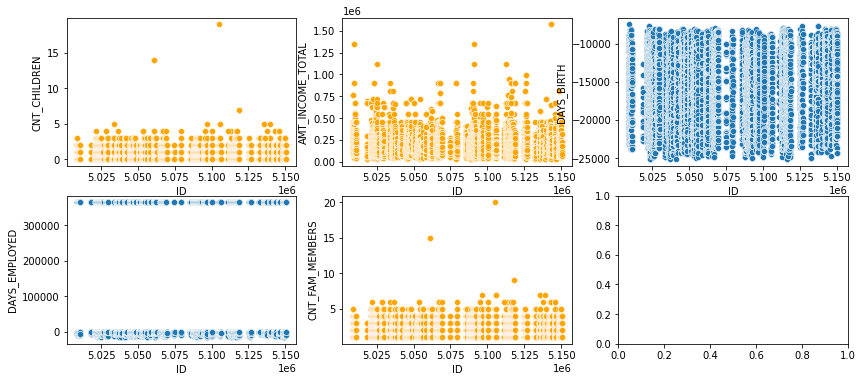

In [22]:
fig, ax = plt.subplots(nrows = 2, ncols = 3, figsize = (14,6))
sns.scatterplot(x = 'ID', y = 'CNT_CHILDREN', data = df, ax = ax[0][0], color = 'orange')
sns.scatterplot(x = 'ID', y = 'AMT_INCOME_TOTAL', data = df, ax = ax[0][1], color = 'orange')
sns.scatterplot(x = 'ID', y = 'DAYS_BIRTH', data = df, ax = ax[0][2])
sns.scatterplot(x = 'ID', y = 'DAYS_EMPLOYED', data = df, ax = ax[1][0])
sns.scatterplot(x = 'ID', y = 'CNT_FAM_MEMBERS', data = df, ax = ax[1][1], color = 'orange')

In [23]:
# DAYS_EMPLOYED, DAYS_BIRTH does not have outliers
df.shape

(36105, 17)

In [24]:
# Removing outliers IQR Technique

q_hi = df['AMT_INCOME_TOTAL'].quantile(0.75)
q_low = df['AMT_INCOME_TOTAL'].quantile(0.25)
IQR = q_hi - q_low
lower_range = q_low - (1.5 * IQR)
upper_range = q_hi + (1.5 * IQR)

df = df[(df['AMT_INCOME_TOTAL'] > lower_range) & (df['AMT_INCOME_TOTAL'] < upper_range)]
df = df[(df['CNT_CHILDREN'] < 8)]
# we can visually see in the plot where our outliers lie and set a cut off accordingly
df = df[(df['CNT_FAM_MEMBERS'] < 8)]

df.shape

(34588, 17)

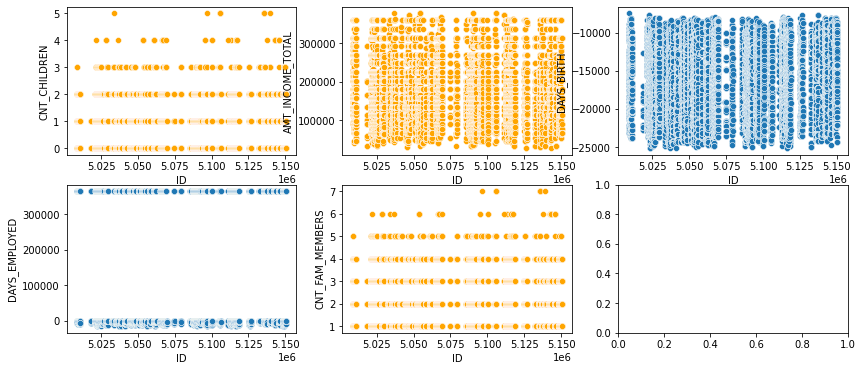

In [25]:
fig, ax = plt.subplots(nrows = 2, ncols = 3, figsize = (14,6))
sns.scatterplot(x = 'ID', y = 'CNT_CHILDREN', data = df, ax = ax[0][0], color = 'orange')
sns.scatterplot(x = 'ID', y = 'AMT_INCOME_TOTAL', data = df, ax = ax[0][1], color = 'orange')
sns.scatterplot(x = 'ID', y = 'DAYS_BIRTH', data = df, ax = ax[0][2])
sns.scatterplot(x = 'ID', y = 'DAYS_EMPLOYED', data = df, ax = ax[1][0])
sns.scatterplot(x = 'ID', y = 'CNT_FAM_MEMBERS', data = df, ax = ax[1][1], color = 'orange')

MODELLING: Test Train Split

In [30]:
new_cols = [col for col in df.columns if col != 'STATUS'] + ['STATUS']
# moving our target variable STATUS column to the last
df = df[new_cols]

X = df.iloc[:, 1:-1]
# independent variables - all columns except STATUS
y = df.iloc[:, -1]
# dependent variable - the last column (STATUS)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)
nms = MinMaxScaler()
X_scaled = pd.DataFrame(nms.fit_transform(X_train), columns = X_train.columns)

sm = SMOTE(random_state = 42)
X_train_res, y_train_res = sm.fit_resample(X_scaled, y_train)
# SMOTE - Synthetic Minority Oversampling Technique
# It creates synthetic data points for the data which is lesser in number in a binary classification
# Here, the no of 0s is far greater than the number of 1s. This may skew the result.
# Smote creates synthetic data points for 1s to avoid this bias

In [31]:
y_train.value_counts()

0    27154
1      516
Name: STATUS, dtype: int64

In [32]:
unique, counts = np.unique(y_train_res, return_counts = True)
print(np.asarray((unique, counts)).T)

[[    0 27154]
 [    1 27154]]


Decision Tree Classifier Model

In [33]:
classifier = DecisionTreeClassifier()
model = classifier.fit(X_train_res, y_train_res)
X_test_scaled = nms.transform(X_test)
prediction = model.predict(X_test_scaled)

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  "X does not have valid feature names, but"


In [ ]:
Model Performance Metrics

In [34]:
print('Accuracy Score is {:.5}'.format(accuracy_score(y_test, prediction)))
print(pd.DataFrame(confusion_matrix(y_test,prediction)))

Accuracy Score is 0.96516
      0    1
0  6638  136
1   105   39


In [37]:
from sklearn.metrics import classification_report
print(classification_report(y_test, prediction))
# accuracy is high but the 1s are not being predicted correctly

              precision    recall  f1-score   support

           0       0.98      0.98      0.98      6774
           1       0.22      0.27      0.24       144

    accuracy                           0.97      6918
   macro avg       0.60      0.63      0.61      6918
weighted avg       0.97      0.97      0.97      6918



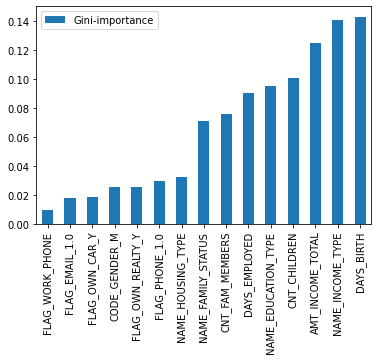

In [39]:
# we attempt to find out which variables are most important in predicting
feats = {}
for feature, importance in zip(X_train.columns, model.feature_importances_):
  feats[feature] = importance

importances = pd.DataFrame.from_dict(feats, orient = 'index').rename(columns = {0:'Gini-importance'})
importances.sort_values(by = 'Gini-importance').plot(kind = 'bar', rot = 90)
model.feature_importances_
importances = model.feature_importances_
indices = np.argsort(importances)

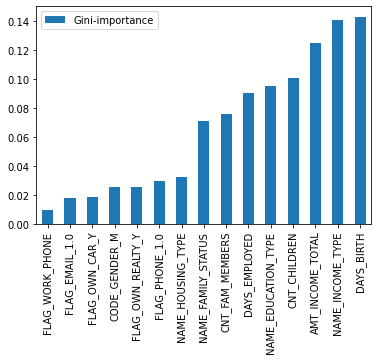

In [40]:
feats = {} # a dict to hold feature_name: feature_importance
for feature, importance in zip(X_train.columns, model.feature_importances_):
    feats[feature] = importance #add the name/value pair 

importances = pd.DataFrame.from_dict(feats, orient='index').rename(columns={0: 'Gini-importance'})
importances.sort_values(by='Gini-importance').plot(kind='bar', rot=90)
model.feature_importances_
importances = model.feature_importances_
indices = np.argsort(importances)

In [43]:
from google.colab import files
import pydotplus
from six import StringIO

dot_data = StringIO()
export_graphviz(model, out_file = dot_data,
                filled = True, rounded = True,
                special_characters = True, feature_names = X.columns, class_names = ['0', '1'])
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())

In [44]:
graph.write_png('Decision_Tree.png')

dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.341191 to fit



True

In [45]:
files.download('Decision_Tree.png')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>